In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import seaborn as sns
from scipy.optimize import minimize

# Enable interactive plots


In [2]:
import warnings

warnings.filterwarnings('error', category=np.ComplexWarning)
# Turn all runtime warnings into errors
warnings.simplefilter("error", RuntimeWarning)
np.seterr(all='warn')  # Convert all NumPy warnings to Python warnings

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## Sytem Model

In [3]:
quantization_levels = 20

# transmit antennas 
Nt = 1
# receiving antennas
Nr = 1

# both tx and rx antennas are placed in uniform linear arrays on vertical walls paraller to each other on a wall
D_1 = 500
D_2 = 520

# wavelenght and frequency of operation
frequency = 2 * (10 ** 9)
wavelength = (3 * (10 ** 8))/frequency
antenna_spacing = wavelength/2

# inter antenna seperation distance
st = wavelength/2
sr = wavelength/2
# seperation between center of adjacent RIS elements in both dimension is
s_ris = wavelength / 2

# RIS size axb
# reflection elements Na, Nb
Na = 20
Nb = 20
N_ris = Na * Nb
Nl = N_ris

# power in db = 10log10(power(watts))

# noise power (untis not mentioned in paper)
# -120 db
noise_power = (10 ** (-12))
# total average power transmit value Pt
# 0 db
Pt = 1

# path loss exponent for direct link influcend by obstacle present
alpha_dir = 3

# racian factor
racian_factor = 1

# backtracking line search parameters
L_note = 10**4
delta = 10 ** (-5)
row = 1/2
min_step_size = 10**(-4)

initial_thetas = np.ones(N_ris, dtype=np.complex64)
P_1 = 1
P_2 = 1

channel_iterations = 10

# dirs should be placed in vicinity of tx or rx
# if near tx Dris = 40
# if near rx Dris = D - 40

# distance between midpoint of RIS and the placne containing tx antennas
d_ris = 40
# distance between mid point of tx antenna arraya nd plane contining RIS is 
lt = 20
# distance between rx antenna dn plane containing RIS
lr_1 = 100
lr_2 = 50


## Channel Model

#### Distance matrices

![Location setup](../location.png)


In [4]:
# Spacing between antennas (in meters)
antenna_spacing = wavelength/2  

######################################################################################################
# Tx coordinates
# x,y coordinates is zeros
tx_antenna_x_coor = np.ones(Nt) * 0
tx_antenna_y_coor = np.arange(Nt-1, -1, -1) * antenna_spacing + lt - ((Nt-1) * antenna_spacing)/2
tx_antenna_z_coor = np.ones(Nt) * 0


######################################################################################################
# Rx coordinates
# x coordinate is D
# y coordinate is zeros
rx_antenna_x_coor_1 = np.ones(Nr) * D_1
rx_antenna_y_coor_1 = np.arange(Nr-1, -1, -1) * antenna_spacing + lr_1 - ((Nr-1) * antenna_spacing)/2
rx_antenna_z_coor_1 = np.ones(Nr) * 0

rx_antenna_x_coor_2 = np.ones(Nr) * D_2
rx_antenna_y_coor_2 = np.arange(Nr-1, -1, -1) * antenna_spacing + lr_2 - ((Nr-1) * antenna_spacing)/2
rx_antenna_z_coor_2 = np.ones(Nr) * 0


######################################################################################################
# RIS coordinates
# on x axis we have Na elements
# on y axis we have Nb elements

# RIS z coordinates are zero
# RIS x coordinates 
col = np.arange(0, Na, 1).reshape(-1, 1)
col = np.tile(col, Nb) * antenna_spacing + d_ris - ((Na-1) * antenna_spacing)/2
ris_elements_x_coor = col.reshape(-1,)

ris_elements_y_coor = np.ones(Na*Nb) * 0

# RIS y coordinates 
col = np.arange(0, Nb, 1)
col = np.tile(col, Na) * antenna_spacing - ((Nb-1) * antenna_spacing)/2
ris_elements_z_coor = col.reshape(-1,)



print(f"""
tx x coordinates shape: {tx_antenna_x_coor.shape}
tx y coordinates shape: {tx_antenna_y_coor.shape}
tx z coordinates shape: {tx_antenna_z_coor.shape}

rx x coordinates shape: {rx_antenna_x_coor_1.shape}
rx y coordinates shape: {rx_antenna_y_coor_1.shape}
rx z coordinates shape: {rx_antenna_z_coor_1.shape}

rx x coordinates shape: {rx_antenna_x_coor_2.shape}
rx y coordinates shape: {rx_antenna_y_coor_2.shape}
rx z coordinates shape: {rx_antenna_z_coor_2.shape}

ris x coordinates shape: {ris_elements_x_coor.shape}
ris y coordinates shape: {ris_elements_y_coor.shape}
ris z coordinates shape: {ris_elements_z_coor.shape}

""")



tx x coordinates shape: (1,)
tx y coordinates shape: (1,)
tx z coordinates shape: (1,)

rx x coordinates shape: (1,)
rx y coordinates shape: (1,)
rx z coordinates shape: (1,)

rx x coordinates shape: (1,)
rx y coordinates shape: (1,)
rx z coordinates shape: (1,)

ris x coordinates shape: (400,)
ris y coordinates shape: (400,)
ris z coordinates shape: (400,)




In [5]:
# Create traces for each variable
trace1 = go.Scatter3d(x=tx_antenna_x_coor, y=tx_antenna_y_coor, z=tx_antenna_z_coor, mode='markers', marker=dict(size=5, color='red'), name='Tx')
trace2 = go.Scatter3d(x=rx_antenna_x_coor_1, y=rx_antenna_y_coor_1, z=rx_antenna_z_coor_1, mode='markers', marker=dict(size=5, color='green'), name='Rx')
trace3 = go.Scatter3d(x=rx_antenna_x_coor_2, y=rx_antenna_y_coor_2, z=rx_antenna_z_coor_2, mode='markers', marker=dict(size=5, color='green'), name='Rx')
trace4 = go.Scatter3d(x=ris_elements_x_coor, y=ris_elements_y_coor, z=ris_elements_z_coor, mode='markers', marker=dict(size=5, color='blue'), name='RIS')

# Create the figure
fig = go.Figure(data=[trace1, trace2, trace3, trace4])

# Add axis labels
fig.update_layout(
    title='3D Plot of Multiple Variables',
    scene=dict(
        xaxis_title='X-axis',
        yaxis_title='Y-axis',
        zaxis_title='Z-axis'
    )
)

# Show the plot
fig.show()


In [6]:
# Caluating distance vectors to be used in calulating path losses
# generate N1xN2 size distance matrix
# i,j elements refer to distance between ith element in mat1 and jth element in mat2
def GenDistanceMatrix(N1, N2, mat1_x, mat1_y, mat1_z, mat2_x, mat2_y, mat2_z):
    distance_matrix = np.zeros((N1, N2))

    for n1 in range(N1):
        for n2 in range(N2):
            distance_matrix[n1,n2] = np.sqrt(
                (mat1_x[n1] - mat2_x[n2]) ** 2 +
                (mat1_y[n1] - mat2_y[n2]) ** 2 +
                (mat1_z[n1] - mat2_z[n2]) ** 2 
            )

    return distance_matrix

# Rx and Tx
distance_r_t_1 = GenDistanceMatrix(Nr, Nt, 
    rx_antenna_x_coor_1, rx_antenna_y_coor_1, rx_antenna_z_coor_1,
    tx_antenna_x_coor, tx_antenna_y_coor, tx_antenna_z_coor
)
distance_r_t_2 = GenDistanceMatrix(Nr, Nt, 
    rx_antenna_x_coor_2, rx_antenna_y_coor_2, rx_antenna_z_coor_2,
    tx_antenna_x_coor, tx_antenna_y_coor, tx_antenna_z_coor
)

# Ris and Tx
distance_ris_t = GenDistanceMatrix(N_ris, Nt, 
    ris_elements_x_coor, ris_elements_y_coor, ris_elements_z_coor,
    tx_antenna_x_coor, tx_antenna_y_coor, tx_antenna_z_coor
)

# RIS and Rx
distance_r_ris_1 = GenDistanceMatrix(Nr, N_ris, 
    rx_antenna_x_coor_1, rx_antenna_y_coor_1, rx_antenna_z_coor_1,
    ris_elements_x_coor, ris_elements_y_coor, ris_elements_z_coor
)
distance_r_ris_2 = GenDistanceMatrix(Nr, N_ris, 
    rx_antenna_x_coor_2, rx_antenna_y_coor_2, rx_antenna_z_coor_2,
    ris_elements_x_coor, ris_elements_y_coor, ris_elements_z_coor
)


print(distance_r_t_1.shape)
print(distance_r_t_2.shape)

print(distance_ris_t.shape)

print(distance_r_ris_1.shape)
print(distance_r_ris_1.shape)

(1, 1)
(1, 1)
(400, 1)
(1, 400)
(1, 400)


In [7]:
# alpha
# Free space pathloss exponent of the direct/indirect link, whose value is influenced by the obstacle present.
def GenHLOS(distance_matrix, wavelength):
    return np.exp(-1j * 2 * np.pi * distance_matrix / wavelength)


# N1, N2 is dimensions of distance matrix used to generate HLOS
def GenHNOLOS(N1, N2, varaince = 1):
    real_part = np.random.normal(0, np.sqrt(varaince/2), (N1, N2))
    imag_part = np.random.normal(0, np.sqrt(varaince/2), (N1, N2))

    return (real_part + 1j * imag_part)


# calculate general H 
def Calculate_H_LOSNLOS(N1, N2, distance_matrix, wavelength, racian_factor):
    H_D_LOS = GenHLOS(distance_matrix, wavelength)
    H_D_NLOS = GenHNOLOS(N1, N2, 2)
    H_LOSNLOS = (np.sqrt(racian_factor) * H_D_LOS + H_D_NLOS)

    return H_LOSNLOS


# calculate H DIR (Direct channel between tx and rx)
# alpha value is influenced by the obstacle present
def Calculate_H_DIR(Nr, Nt, distance_matrix_r_t, wavelength, alpha_dir, D, lt, lr, racian_factor):
    d_note = np.sqrt((D ** 2) + ((lt-lr) ** 2))
    beta_DIR = ((4 * np.pi / wavelength) ** 2) * (d_note ** alpha_dir)
    
    H_DIR = np.sqrt(1/(beta_DIR * (racian_factor + 1))) * Calculate_H_LOSNLOS(Nr, Nt, distance_matrix_r_t, wavelength, racian_factor)
    return H_DIR


def Calculate_H1(N_ris, Nt, distance_matrix_ris_t, wavelength, racian_factor, beta_INDIR_inverse):
    return  np.sqrt(beta_INDIR_inverse/(racian_factor + 1)) * Calculate_H_LOSNLOS(N_ris, Nt, distance_matrix_ris_t, wavelength, racian_factor)


def Calculate_H2(Nr, N_ris, distance_matrix_r_ris, wavelength, racian_factor):
    return np.sqrt(1/(racian_factor + 1)) * Calculate_H_LOSNLOS(Nr, N_ris, distance_matrix_r_ris, wavelength, racian_factor)


# calculate H INDIR (Infirect Direct channel between tx and rx)
def Calculate_H_INDIR(H1, H2, thetas, beta_INDIR_inverse):
    F_theta = np.diag(thetas)
    H_INDIR = np.matmul(H2, np.matmul(F_theta, H1))

    return H_INDIR


def Calculate_H(HDIR, HINDIR):
    return HDIR + HINDIR

    

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_complex_matrix_line(H, name):
    """
    Plots real and imaginary parts of a complex matrix H as line plots.
    Matrix is flattened row-wise.
    """
    H = np.array(H).flatten()
    
    plt.figure(figsize=(8, 4))
    plt.plot(np.real(H), label='Real Part', color='blue')
    plt.plot(np.imag(H), label='Imaginary Part', color='orange')
    
    plt.xlabel('Element Index')
    plt.ylabel('Value')
    plt.title(f'Line Plot of Real and Imaginary Parts of Complex Matrix {name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1
(1, 1)
(1, 1)
(400, 1)
(400, 1)
(1, 400)
(1, 400)
(1, 1)
(1, 1)


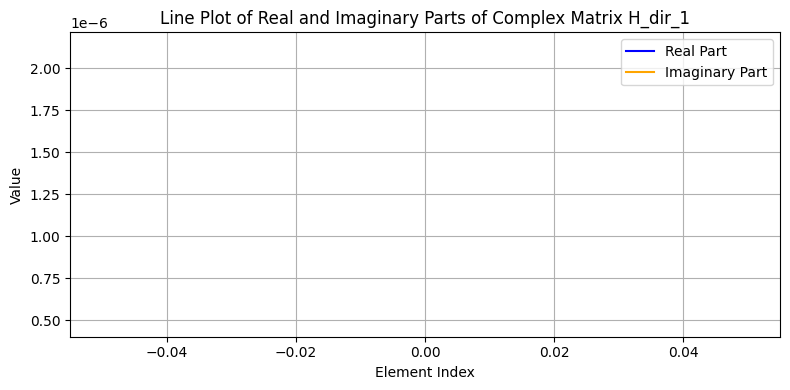

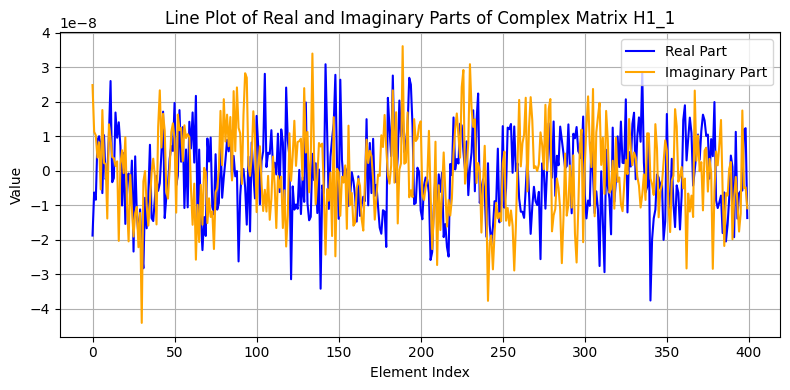

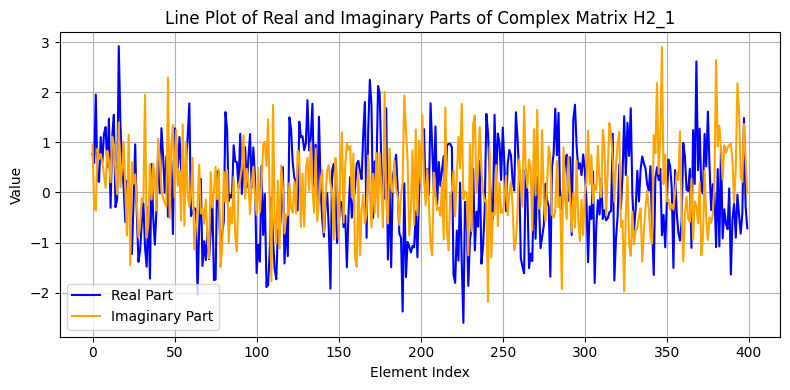

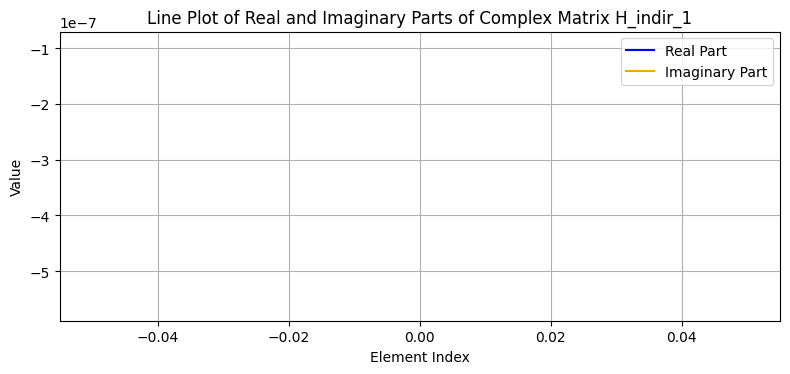

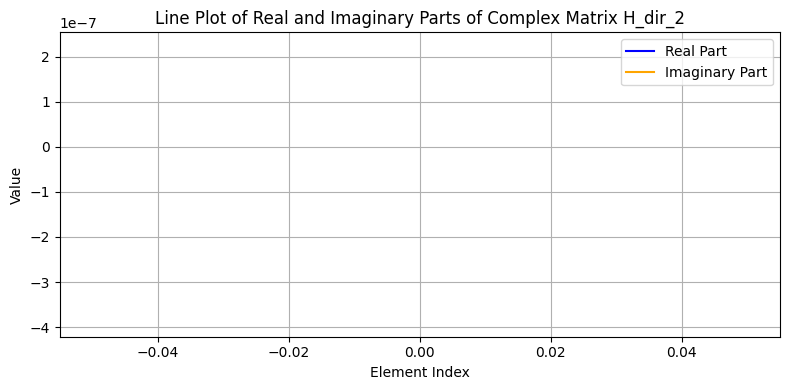

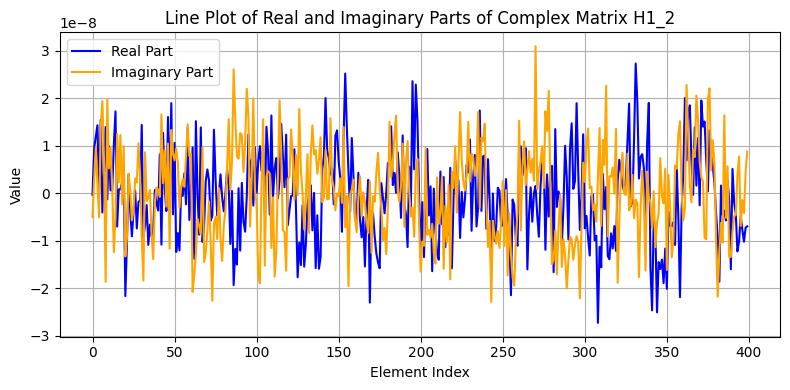

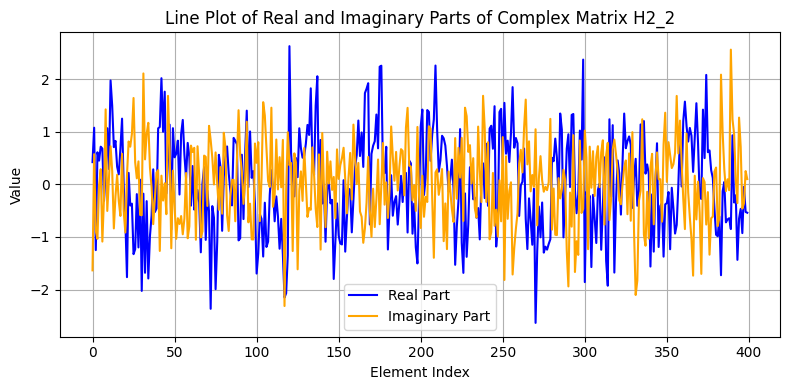

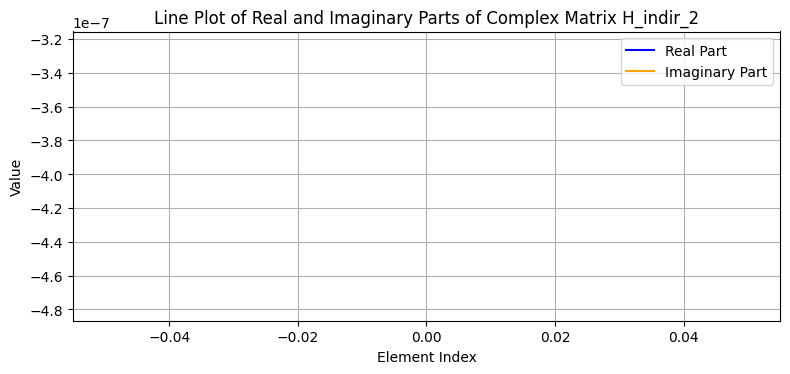

In [9]:
average_over = 1
step_boost = 0
print(racian_factor)

d1 = np.sqrt((d_ris ** 2) + (lt ** 2))
d2_1 = np.sqrt((D_1 - d_ris) ** 2 + lr_1 ** 2)
d2_2 = np.sqrt((D_2 - d_ris) ** 2 + lr_2 ** 2)

beta_INDIR_inverse_1 = ((wavelength**4)/(256 * (np.pi ** 2))) * (((lt/d1 + lr_1/d2_1)**2) / ((d1*d2_1)**2))
beta_INDIR_inverse_2 = ((wavelength**4)/(256 * (np.pi ** 2))) * (((lt/d1 + lr_2/d2_2)**2) / ((d1*d2_1)**2))

H_dir_1 = Calculate_H_DIR(Nr, Nt, distance_r_t_1, wavelength, alpha_dir, D_1, lt, lr_1, racian_factor)
H1_1 = Calculate_H1(N_ris, Nt, distance_ris_t, wavelength, racian_factor, beta_INDIR_inverse_1)
H2_1 = Calculate_H2(Nr, N_ris, distance_r_ris_1, wavelength, racian_factor)
H_indir_1 = Calculate_H_INDIR(H1_1, H2_1, initial_thetas, beta_INDIR_inverse_1)

H_dir_2 = Calculate_H_DIR(Nr, Nt, distance_r_t_2, wavelength, alpha_dir, D_2, lt, lr_2, racian_factor)
H1_2 = Calculate_H1(N_ris, Nt, distance_ris_t, wavelength, racian_factor, beta_INDIR_inverse_2)
H2_2 = Calculate_H2(Nr, N_ris, distance_r_ris_2, wavelength, racian_factor)
H_indir_2 = Calculate_H_INDIR(H1_2, H2_2, initial_thetas, beta_INDIR_inverse_2)

print(H_dir_1.shape)
print(H_dir_2.shape)

print(H1_1.shape)
print(H1_2.shape)

print(H2_1.shape)
print(H2_2.shape)

print(H_indir_1.shape)
print(H_indir_2.shape)


plot_complex_matrix_line(H_dir_1, 'H_dir_1')
plot_complex_matrix_line(H1_1, 'H1_1')
plot_complex_matrix_line(H2_1, 'H2_1')
plot_complex_matrix_line(H_indir_1, 'H_indir_1')
plot_complex_matrix_line(H_dir_2, 'H_dir_2')
plot_complex_matrix_line(H1_2, 'H1_2')
plot_complex_matrix_line(H2_2, 'H2_2')
plot_complex_matrix_line(H_indir_2, 'H_indir_2')

In [10]:
def Rate(Hdir_1, H2_1, H1_1, Hdir_2, H2_2, H1_2, myomega, P1, P2, noise_power):
    
    h_1 = (Hdir_1 + H2_1 @ np.diag(myomega) @ H1_1)[0,0]
    h_2 = (Hdir_2 + H2_2 @ np.diag(myomega) @ H1_2)[0,0]
    if(np.abs(h_1) < np.abs(h_2)):
        rate = np.log2(1 + P2 * ((np.abs(h_2)) ** 2) / noise_power) + np.log2(1 + P1 * ((np.abs(h_1)) ** 2) / (P2 * ((np.abs(h_1)) ** 2) + noise_power))
        return rate
    else:
        rate = np.log2(1 + P1 * ((np.abs(h_1)) ** 2) / noise_power) + np.log2(1 + P2 * ((np.abs(h_2)) ** 2) / (P1 * ((np.abs(h_2)) ** 2) + noise_power))
        return rate



## Projected Gradient Method

In [11]:
def Calculate_Kappa(H_dir, H2, H1, Pt):
    if H_dir.all() == 0:
        return 1000
    else :
        return 1000 * max(1, 1/np.sqrt(Pt)) * np.sqrt( np.linalg.norm(H_dir)/ np.linalg.norm(np.matmul(H2, H1)))

def grad_P1(h1, P1, P2, noise_power):
    abs_h1 = abs(h1)
    grad = (1/np.log(2)) * (abs_h1 ** 2) / ((abs_h1 ** 2) * (P1 + P2) + noise_power)
    return grad

def grad_P2(h1, h2, P1, P2, noise_power):
    # Calculate the absolute values of h1 and h2
    abs_h1 = abs(h1)
    abs_h2 = abs(h2)

    # Calculate the terms in the numerator
    term1_numerator = -P1 * (abs_h1 ** 4)
    term2_numerator = abs_h2 ** 2

    # Calculate the terms in the denominator
    term1_denominator = (abs_h1**2 * (P1 + P2) + noise_power) * (P2 * abs_h1**2 + noise_power)
    term2_denominator = P2 * (abs_h2 ** 2) + noise_power

    term1 = term1_numerator / term1_denominator
    term2 = term2_numerator / term2_denominator

    # Calculate the final result
    grad = (1 / np.log(2)) * (term1 + term2)
    return grad

def grad_RIS(
    theta,
    H_dir_1,         
    H_dir_2,         
    H1_1, H1_2,
    H2_1, H2_2,
    P1, P2, N0       
):
    H1_1 = H1_1.reshape(-1,)
    H2_1 = H2_1.reshape(-1,)
    H1_2 = H1_2.reshape(-1,)
    H2_2 = H2_2.reshape(-1,)
    
    
    # Step 1: Diagonal matrix F(theta)
    F_theta = np.diag(np.exp(1j * theta))  # shape: (Nr, Nr)

    # Step 2: Compute h1 and h2
    h1 = (H_dir_1 + H2_1 @ (F_theta @ H1_1))[0,0]  # scalar
    h2 = (H_dir_2 + H2_2 @ (F_theta @ H1_2))[0,0]  # scalar
    
    # Step 3: Compute S1, S2 and alphas
    S1 = np.abs(h1)**2
    S2 = np.abs(h2)**2
    alpha1 = (P1 * N0) / ((P2 * S1 + N0) * (P1 * S1 + P2 * S1 + N0) * np.log(2))
    alpha2 = (P2) / ((P2 * S2 + N0) * np.log(2))
    

    # Step 4: Element-wise complex products
    a1 = H2_1 * H1_1   # shape: (Nr,)
    a2 = H2_2 * H1_2   # shape: (Nr,)
    
    del_x = alpha1 * (2 * np.real(a1 * np.conj(h1))) + alpha2 * (2 * np.real(a2 * np.conj(h2)))
    del_y = alpha1 * (2 * np.real(1j * a1 * np.conj(h1))) + alpha2 * (2 * np.real(1j * a2 * np.conj(h2)))

    # Step 5: Final complex gradient
    gradient_complex = del_x + 1j * del_y

    return gradient_complex

def cov_mat_proj(p1, p2, Pt):
    P1 = 0
    P2 = 0
    P1 = (p1 - p2 + Pt)/2
    P2 = Pt - P1
    if((P1 > 0 and P2 > 0) or P1 < 0 and P2 < 0):
        return abs(P1), abs(P2)
    elif(P1 <= 0):
        return 0, Pt
    else:
        return Pt, 0

def project_onto_unit_circle(x):
    return x / np.abs(x)

    
def PGM(max_iterations, H_dir_1, H1_1, H2_1, H_dir_2, H1_2, H2_2, intial_p1, intial_p2, initial_thetas, noise_power, Pt, stepsize = 10):
    # stepsize = 10

    kappa = max(Calculate_Kappa(H_dir_1, H2_1, H1_1, Pt), Calculate_Kappa(H_dir_2, H2_2, H1_2, Pt))
    thetas = initial_thetas / kappa
    P1 = (kappa ** 2) * Pt / 2
    P2 = (kappa ** 2) * Pt / 2
    Pt = (kappa ** 2) * Pt 

    H_dir_1 = H_dir_1 / (kappa)
    H_dir_2 = H_dir_2 / (kappa)

    initial_rate = Rate(H_dir_1, H2_1, H1_1, H_dir_2, H2_2, H1_2, thetas, P1, P2, noise_power)
    rate = initial_rate
    rates = np.zeros(max_iterations+1)
    rates[0] = rate

    i = 1
    # algo run for max_iteration times or rate convergers
    while i < max_iterations+1:
    # for i in range(1, max_iterations+1):
        if(i%1000 == 0):
            print(f"Iter: {i}")
        
        h_1 = (H_dir_1 + H2_1 @ np.diag(thetas) @ H1_1)[0,0]
        h_2 = (H_dir_2 + H2_2 @ np.diag(thetas) @ H1_2)[0,0]
        del_P1 = None
        del_P2 = None
        del_thetas = None
        
        if(np.abs(h_1) > np.abs(h_2)):
            del_P1 = grad_P2(h_2, h_1, P2, P1, noise_power)
            del_P2 = grad_P1(h_2, P2, P1, noise_power)
            del_thetas = grad_RIS(thetas, H_dir_2, H_dir_1, H1_2, H1_1, H2_2, H2_1,P2, P1, noise_power)
            
        else:
            del_P1 = grad_P1(h_1, P1, P2, noise_power)
            del_P2 = grad_P2(h_1, h_2, P1, P2, noise_power)
            del_thetas = grad_RIS(thetas, H_dir_1, H_dir_2, H1_1, H1_2, H2_1, H2_2,P1, P2, noise_power)
        
        P1_new = P1 + stepsize * del_P1
        P2_new = P2 + stepsize * del_P2
        P1_new, P2_new = cov_mat_proj(P1_new, P2_new, Pt)

        thetas_new = thetas + stepsize * del_thetas
        thetas_new = project_onto_unit_circle(thetas_new)
        thetas_new = thetas_new / kappa

        rate_new = Rate(H_dir_1, H2_1, H1_1, H_dir_2, H2_2, H1_2, thetas_new, P1_new, P2_new, noise_power)
        P1 = P1_new
        P2 = P2_new
        thetas = thetas_new
        rate = rate_new
        rates[i] = rate
        rates[i] = rate
        i = i+1
        
    return [rates, 1, 1]

    
def PGM_modified(max_iterations, H_dir_1, H1_1, H2_1, H_dir_2, H1_2, H2_2, intial_p1, intial_p2, initial_thetas, noise_power, Pt, stepsize = 10):
    delta = 1e-5
    rho = 0.5
    stepsize = 10000
    
    kappa = max(Calculate_Kappa(H_dir_1, H2_1, H1_1, Pt), Calculate_Kappa(H_dir_2, H2_2, H1_2, Pt))
    
    thetas = initial_thetas / kappa
    P1 = (kappa ** 2) / 2
    P2 = (kappa ** 2) / 2
    Pt = (kappa ** 2) * Pt 

    H_dir_1 = H_dir_1 / (kappa)
    H_dir_2 = H_dir_2 / (kappa)

    initial_rate = Rate(H_dir_1, H2_1, H1_1, H_dir_2, H2_2, H1_2, thetas, P1, P2, noise_power)
    rate = initial_rate
    rates = np.zeros(max_iterations+1)
    rates[0] = rate

    i = 1
    # algo run for max_iteration times or rate convergers
    while i < max_iterations+1:
        
    # for i in range(1, max_iterations+1):
        if(i%1000 == 0):
            print(f"Iter: {i}")
        
        h_1 = (H_dir_1 + H2_1 @ np.diag(thetas) @ H1_1)[0,0]
        h_2 = (H_dir_2 + H2_2 @ np.diag(thetas) @ H1_2)[0,0]
        del_P1 = None
        del_P2 = None
        del_thetas = None
        
        if(np.abs(h_1) > np.abs(h_2)):
            del_P1 = grad_P2(h_2, h_1, P2, P1, noise_power)
            del_P2 = grad_P1(h_2, P2, P1, noise_power)
            del_thetas = grad_RIS(thetas, H_dir_2, H_dir_1, H1_2, H1_1, H2_2, H2_1,P2, P1, noise_power)
            
        else:
            del_P1 = grad_P1(h_1, P1, P2, noise_power)
            del_P2 = grad_P2(h_1, h_2, P1, P2, noise_power)
            del_thetas = grad_RIS(thetas, H_dir_1, H_dir_2, H1_1, H1_2, H2_1, H2_2,P1, P2, noise_power)
        
        
        for _ in range(31):
            P1_new = P1 + stepsize * del_P1
            P2_new = P2 + stepsize * del_P2
            P1_new, P2_new = cov_mat_proj(P1_new, P2_new, Pt)

            thetas_new = thetas + stepsize * del_thetas
            thetas_new = project_onto_unit_circle(thetas_new)
            thetas_new = thetas_new / kappa

            rate_new = Rate(H_dir_1, H2_1, H1_1, H_dir_2, H2_2, H1_2, thetas_new, P1_new, P2_new, noise_power)
            
            if (rate_new - rate >= delta * (((P1_new - P1) ** 2 + (P2_new - P2) ** 2) + np.linalg.norm(thetas_new - thetas) ** 2)) or (stepsize < 1e-4):
                thetas = thetas_new
                P1 = P1_new
                P2 = P2_new
                rate = rate_new
                break
            else:
                stepsize *= rho
                
        rates[i] = rate
        i = i + 1
        
    return [rates, 1, 1]

def PGM_quantized(max_iterations, H_dir_1, H1_1, H2_1, H_dir_2, H1_2, H2_2, intial_p1, intial_p2, initial_thetas, noise_power, Pt, stepsize, theta_quant_size):
    delta = 1e-5
    rho = 0.5
    stepsize = 10000
    
    kappa = max(Calculate_Kappa(H_dir_1, H2_1, H1_1, Pt), Calculate_Kappa(H_dir_2, H2_2, H1_2, Pt))
    
    thetas = initial_thetas / kappa
    P1 = (kappa ** 2) / 2
    P2 = (kappa ** 2) / 2
    Pt = (kappa ** 2) * Pt 

    H_dir_1 = H_dir_1 / (kappa)
    H_dir_2 = H_dir_2 / (kappa)

    initial_rate = Rate(H_dir_1, H2_1, H1_1, H_dir_2, H2_2, H1_2, thetas, P1, P2, noise_power)
    rate = initial_rate
    rates = np.zeros(max_iterations+1)
    rates[0] = rate

    i = 1
    # algo run for max_iteration times or rate convergers
    while i < max_iterations+1:
        
    # for i in range(1, max_iterations+1):
        # if(i%1000 == 0):
        #     print(f"Iter: {i}")
        
        h_1 = (H_dir_1 + H2_1 @ np.diag(thetas) @ H1_1)[0,0]
        h_2 = (H_dir_2 + H2_2 @ np.diag(thetas) @ H1_2)[0,0]
        del_P1 = None
        del_P2 = None
        del_thetas = None
        
        if(np.abs(h_1) > np.abs(h_2)):
            del_P1 = grad_P2(h_2, h_1, P2, P1, noise_power)
            del_P2 = grad_P1(h_2, P2, P1, noise_power)
            del_thetas = grad_RIS(thetas, H_dir_2, H_dir_1, H1_2, H1_1, H2_2, H2_1,P2, P1, noise_power)
            
        else:
            del_P1 = grad_P1(h_1, P1, P2, noise_power)
            del_P2 = grad_P2(h_1, h_2, P1, P2, noise_power)
            del_thetas = grad_RIS(thetas, H_dir_1, H_dir_2, H1_1, H1_2, H2_1, H2_2,P1, P2, noise_power)
        
        
        for _ in range(31):
            P1_new = P1 + stepsize * del_P1
            P2_new = P2 + stepsize * del_P2
            P1_new, P2_new = cov_mat_proj(P1_new, P2_new, Pt)

            thetas_new = thetas + stepsize * del_thetas
            thetas_new = project_onto_unit_circle(thetas_new)
            thetas_new = thetas_new / kappa

            rate_new = Rate(H_dir_1, H2_1, H1_1, H_dir_2, H2_2, H1_2, thetas_new, P1_new, P2_new, noise_power)
            
            if (rate_new - rate >= delta * (((P1_new - P1) ** 2 + (P2_new - P2) ** 2) + np.linalg.norm(thetas_new - thetas) ** 2)) or (stepsize < 1e-4):
                thetas = thetas_new
                P1 = P1_new
                P2 = P2_new
                rate = rate_new
                break
            else:
                stepsize *= rho
                
        rates[i] = rate
        i = i + 1
        
        angle_rad = np.angle(thetas * kappa, deg=False)
    
        # Map angles to [0, 2π)
        angles_rad_2pi = angle_rad + (angle_rad < 0) * 2 * np.pi
        
        quantized_angles = quantize_angles(angles_rad_2pi, theta_quant_size)
        thetas = np.exp(1j * quantized_angles) / kappa
        
        rate = Rate(H_dir_1, H2_1, H1_1, H_dir_2, H2_2, H1_2, thetas, P1, P2, noise_power)
        rates[-2] = rates[-1]
        rates[-1] = rate
    return [rates, 1, 1]



def quantize_angles(angles, n):
    """
    Quantizes the angles between 0 and 2π into n levels.

    Args:
    angles (numpy array): Array of angles between 0 and 2π.
    n (int): Number of quantization levels.

    Returns:
    numpy array: Quantized angles.
    """
    
    # Generate quantization levels
    quant_levels = np.linspace(0, 2 * np.pi, n, endpoint=False)
    
    # Find the closest quantization level for each angle
    quantized_angles = np.array([quant_levels[np.argmin(np.abs(quant_levels - angle))] for angle in angles])
    
    return quantized_angles

        

In [12]:
# max_iterations = 100000
# step_size = 0.05
max_iterations = 500
step_size = 0.01
rate_average = np.zeros(max_iterations+1)
average_over = 50
step_boost = 0


for i in range(average_over):
    d1_1 = np.sqrt(d_ris ** 2 + lt ** 2)
    d2_1 = np.sqrt((D_1 - d_ris) ** 2 + lr_1 ** 2)
    beta_INDIR_inverse_1 = ((wavelength**4)/(256 * (np.pi ** 2))) * (((lt/d1 + lr_1/d2_1)**2) / ((d1*d2_1)**2))

    d1_2 = np.sqrt(d_ris ** 2 + lt ** 2)
    d2_2 = np.sqrt((D_2 - d_ris) ** 2 + lr_2 ** 2)
    beta_INDIR_inverse_2 = ((wavelength**4)/(256 * (np.pi ** 2))) * (((lt/d1 + lr_2/d2_2)**2) / ((d1*d2_2)**2))


    H_dir_1 = Calculate_H_DIR(Nr, Nt, distance_r_t_1, wavelength, alpha_dir, D_1, lt, lr_1, racian_factor)
    H1_1 = Calculate_H1(N_ris, Nt, distance_ris_t, wavelength, racian_factor, beta_INDIR_inverse_1)
    H2_1 = Calculate_H2(Nr, N_ris, distance_r_ris_1, wavelength, racian_factor)

    H_dir_2 = Calculate_H_DIR(Nr, Nt, distance_r_t_2, wavelength, alpha_dir, D_2, lt, lr_2, racian_factor)
    H1_2 = Calculate_H1(N_ris, Nt, distance_ris_t, wavelength, racian_factor, beta_INDIR_inverse_2)
    H2_2 = Calculate_H2(Nr, N_ris, distance_r_ris_2, wavelength, racian_factor)
    
    print(f"PGM for {i+1}th channel")
    [rates, tt, qq] = PGM(max_iterations, H_dir_1, H1_1, H2_1, H_dir_2, H1_2, H2_2, 1/2, 1/2,  initial_thetas, noise_power, Pt, step_size)
    rate_average += rates / average_over

# rate_average = rate_average 

    

PGM for 1th channel
PGM for 2th channel
PGM for 3th channel
PGM for 4th channel
PGM for 5th channel
PGM for 6th channel
PGM for 7th channel
PGM for 8th channel
PGM for 9th channel
PGM for 10th channel
PGM for 11th channel
PGM for 12th channel
PGM for 13th channel
PGM for 14th channel
PGM for 15th channel
PGM for 16th channel
PGM for 17th channel
PGM for 18th channel
PGM for 19th channel
PGM for 20th channel
PGM for 21th channel
PGM for 22th channel
PGM for 23th channel
PGM for 24th channel
PGM for 25th channel
PGM for 26th channel
PGM for 27th channel
PGM for 28th channel
PGM for 29th channel
PGM for 30th channel
PGM for 31th channel
PGM for 32th channel
PGM for 33th channel
PGM for 34th channel
PGM for 35th channel
PGM for 36th channel
PGM for 37th channel
PGM for 38th channel
PGM for 39th channel
PGM for 40th channel
PGM for 41th channel
PGM for 42th channel
PGM for 43th channel
PGM for 44th channel
PGM for 45th channel
PGM for 46th channel
PGM for 47th channel
PGM for 48th channel
P

In [13]:
# Create the line plot
normal_rate_fig = go.Figure(data=go.Scatter(
    x=np.log10(np.arange(0, len(rates))+1),
    y=rate_average, 
    mode='lines+markers',  # Line + Markers
    marker=dict(size=4, color='red'),  # Marker style
    line=dict(color='blue', width=1),  # Line style
    name='Line with Markers'
))

# Add titles and labels
normal_rate_fig.update_layout(
    title='Achivable Rate(dirs = 40)',
    xaxis_title='Iteration number (10 raise to the power)',
    yaxis_title='Rate (bit/s/Hz)',  # Optional: Dark theme, change if needed
)

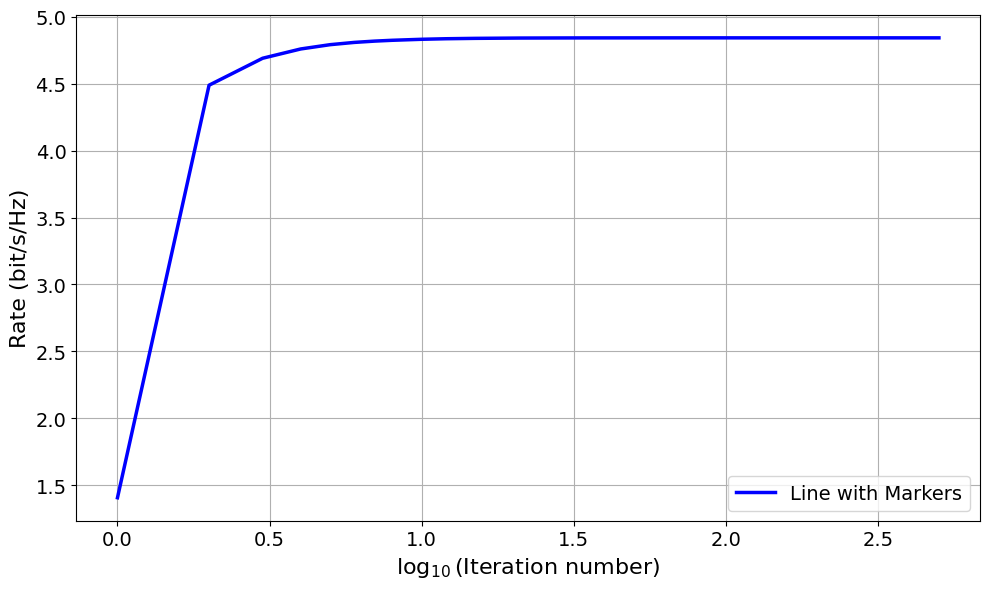

In [16]:

# X-axis: log10(index + 1)
x_vals = np.log10(np.arange(0, len(rates)) + 1)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the line with markers
plt.plot(x_vals, rate_average,
         color='blue', linewidth=2.5,
         markerfacecolor='red', markeredgecolor='red',
         markersize=6, label='Line with Markers')

# Add title and axis labels
# plt.title('Achievable Rate (dirs = 40)', fontsize=18, fontweight='bold')
plt.xlabel(r'$\log_{10}(\mathrm{Iteration\ number})$', fontsize=16)
plt.ylabel('Rate (bit/s/Hz)', fontsize=16)

# Customize ticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add grid and legend
plt.grid(True)
plt.legend(fontsize=14)

# Optimize layout
plt.tight_layout()

# Show plot
plt.show()

In [61]:
# max_iterations = 100000
# step_size = 0.05
max_iterations = 250
step_size = 0.05
rate_average = np.zeros(max_iterations+1)
average_over = 20
step_boost = 0

max_rates = np.zeros(10)
quantized_rate = np.zeros(10)

for i in range(average_over):
    
    d1_1 = np.sqrt(d_ris ** 2 + lt ** 2)
    d2_1 = np.sqrt((D_1 - d_ris) ** 2 + lr_1 ** 2)
    beta_INDIR_inverse_1 = ((wavelength**4)/(256 * (np.pi ** 2))) * (((lt/d1 + lr_1/d2_1)**2) / ((d1*d2_1)**2))

    d1_2 = np.sqrt(d_ris ** 2 + lt ** 2)
    d2_2 = np.sqrt((D_2 - d_ris) ** 2 + lr_2 ** 2)
    beta_INDIR_inverse_2 = ((wavelength**4)/(256 * (np.pi ** 2))) * (((lt/d1 + lr_2/d2_2)**2) / ((d1*d2_2)**2))


    H_dir_1 = Calculate_H_DIR(Nr, Nt, distance_r_t_1, wavelength, alpha_dir, D_1, lt, lr_1, racian_factor)
    H1_1 = Calculate_H1(N_ris, Nt, distance_ris_t, wavelength, racian_factor, beta_INDIR_inverse_1)
    H2_1 = Calculate_H2(Nr, N_ris, distance_r_ris_1, wavelength, racian_factor)

    H_dir_2 = Calculate_H_DIR(Nr, Nt, distance_r_t_2, wavelength, alpha_dir, D_2, lt, lr_2, racian_factor)
    H1_2 = Calculate_H1(N_ris, Nt, distance_ris_t, wavelength, racian_factor, beta_INDIR_inverse_2)
    H2_2 = Calculate_H2(Nr, N_ris, distance_r_ris_2, wavelength, racian_factor)
    
    for theta_step_size in range(1, 11):
        qrate_average = np.zeros(max_iterations+1)
        print(f"\nstep size {theta_step_size}, \n Channel: ", end=" ")
        
        print(f"{i}", end = " ")
        [rates, tt, qq] = PGM_quantized(max_iterations, H_dir_1, H1_1, H2_1, H_dir_2, H1_2, H2_2, 1/2, 1/2,  initial_thetas, noise_power, Pt, step_size, 2** theta_step_size)
        qrate_average += rates

        max_rates[theta_step_size-1] += qrate_average[-2] / average_over
        quantized_rate[theta_step_size-1] += qrate_average[-1] / average_over

# rate_average = rate_average 

    


step size 1, 
 Channel:  0 
step size 2, 
 Channel:  0 
step size 3, 
 Channel:  0 
step size 4, 
 Channel:  0 
step size 5, 
 Channel:  0 
step size 6, 
 Channel:  0 
step size 7, 
 Channel:  0 
step size 8, 
 Channel:  0 
step size 9, 
 Channel:  0 
step size 10, 
 Channel:  0 
step size 1, 
 Channel:  1 
step size 2, 
 Channel:  1 
step size 3, 
 Channel:  1 
step size 4, 
 Channel:  1 
step size 5, 
 Channel:  1 
step size 6, 
 Channel:  1 
step size 7, 
 Channel:  1 
step size 8, 
 Channel:  1 
step size 9, 
 Channel:  1 
step size 10, 
 Channel:  1 
step size 1, 
 Channel:  2 
step size 2, 
 Channel:  2 
step size 3, 
 Channel:  2 
step size 4, 
 Channel:  2 
step size 5, 
 Channel:  2 
step size 6, 
 Channel:  2 
step size 7, 
 Channel:  2 
step size 8, 
 Channel:  2 
step size 9, 
 Channel:  2 
step size 10, 
 Channel:  2 
step size 1, 
 Channel:  3 
step size 2, 
 Channel:  3 
step size 3, 
 Channel:  3 
step size 4, 
 Channel:  3 
step size 5, 
 Channel:  3 
step size 6, 
 C

In [61]:
print(quantized_rate)

[       nan 5.92382094 6.31226087 6.28402183 6.31915387 6.34110589
 6.32330307 6.33562844 6.33286304 6.33260059]


In [62]:
# Create traces for real part
mixfigure = go.Figure()
mixfigure.add_trace(go.Scatter(x=np.arange(1, 11), y=max_rates, mode='lines+markers', name='Non qantized'))
mixfigure.add_trace(go.Scatter(x=np.arange(1, 11), y=quantized_rate, mode='lines+markers', name='Quantized'))

# Add titles and labels
mixfigure.update_layout(
    title='Achivable Rate (dirs = 40)',
    xaxis_title='Qunatization level (2 raise to the power)',
    yaxis_title='Rate (bit/s/Hz)'
)